Dataset: https://www.kaggle.com/c/painter-by-numbers/data

Tensorflow Tutorial: https://www.tensorflow.org/tutorials/generative/dcgan



In [1]:
import math
from random import randint
import random
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import layers, models
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import sys, os
import time
from IPython import display

In [2]:
dataset_dir = '../Datasets/Painting/'

dataset = pd.read_csv(dataset_dir + 'train_info.csv')
dataset.head()

,filename,artist,title,style,genre,date
0,102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0
1,75232.jpg,5b39c876740bfc1cfaf544721c43cac3,Vir Heroicus Sublimis,Color Field Painting,abstract,1950.0
2,29855.jpg,96e5bc98488ed589b9bf17ad9fd09371,Night March of a Hundred Demons (left half),Yamato-e,mythological painting,NaN
3,62252.jpg,5b39c876740bfc1cfaf544721c43cac3,"Who’s Afraid of Red, Yellow and Blue II",Color Field Painting,abstract,NaN
4,63861.jpg,5b39c876740bfc1cfaf544721c43cac3,Black Fire I,Color Field Painting,abstract,1963.0


In [3]:
dataset.shape

(79433, 6)

In [4]:
all_abstract_paintings = dataset[dataset['filename'].str.startswith('1')][dataset['genre'] == 'cityscape']
all_abstract_paintings

<ipython-input-4-71cbeeff7c61>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  all_abstract_paintings = dataset[dataset['filename'].str.startswith('1')][dataset['genre'] == 'cityscape']


,filename,artist,title,style,genre,date
31,19385.jpg,bf1267ceacfea1e3b977e5f3f904e0d6,Gelmeroda IX,Cubism,cityscape,1926.0
425,11889.jpg,96e7b1bc8d52e18caf0af34fec2e9bcb,Vedute di Roma,Neoclassicism,cityscape,NaN
493,14108.jpg,96e7b1bc8d52e18caf0af34fec2e9bcb,Vedute di Roma,Neoclassicism,cityscape,NaN
519,13949.jpg,612edcdb31a0860c982b1833fc1e6d17,The Neuer Marktplatz in Dresden,Rococo,cityscape,1747
555,1155.jpg,96e7b1bc8d52e18caf0af34fec2e9bcb,Vedute di Roma,Neoclassicism,cityscape,NaN
...,...,...,...,...,...,...
78812,15318.jpg,c651cd8d7b797691f2a8141facc80b2a,From my garden,Neo-Expressionism,cityscape,1949.0
78968,101920.jpg,5aab341fe07e8b2f191a565a7451e709,Doca do Peixe,Expressionism,cityscape,1933.0
79040,11183.jpg,c53cd801911da5304574dd3657f3f90e,Cityscape with Bridge,Futurism,cityscape,1910.0
79044,17771.jpg,803944a850b21d26d1551a67ad172656,Night in Reykjavík,Impressionism,cityscape,1916


In [5]:
abstract_painting_filename = np.array(all_abstract_paintings['filename'])
image_size = 50

In [6]:
def load_images():
    images = []
    for i in range(len(abstract_painting_filename)): # 
        image = load_img(dataset_dir + 'train_1/' + abstract_painting_filename[i], grayscale=True)
        # img = img_to_array(img)
        image = image.resize((image_size, image_size))
        image = img_to_array(image).astype('float32')
        image = (image - 127.5) / 127.5
        # print(image)
        images.append(image)
    
    return images

In [7]:
images = load_images()

c:\program files\python38\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [8]:
def plot_images(images):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.grid(False)
        plt.imshow(images[i], 'gray')
    plt.show()

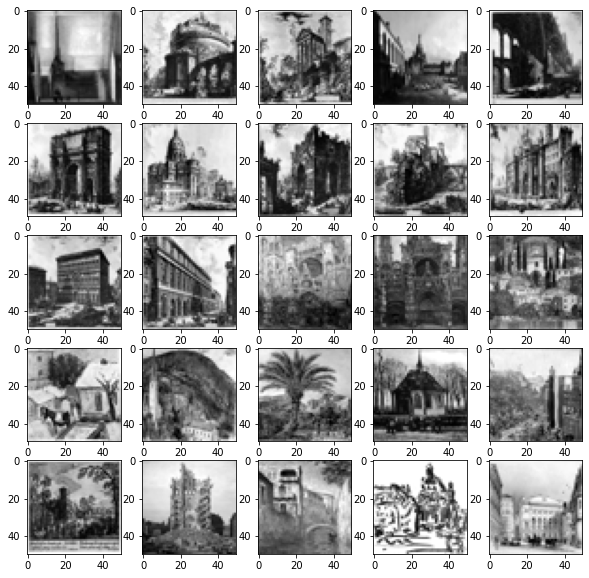

In [9]:
plot_images (images)

In [10]:
BUFFER_SIZE = 1000
BATCH_SIZE = 100

image_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
# Taken from: https://www.tensorflow.org/tutorials/generative/dcgan

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(image_size*image_size, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_size, image_size, 1)))
    assert model.output_shape == (None, image_size, image_size, 1) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), padding='same', use_bias=False))
    assert model.output_shape == (None, image_size, image_size, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, image_size, image_size, 1)

    return model

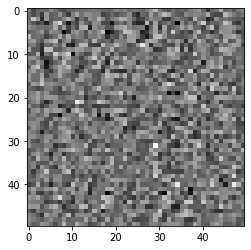

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# img = Image.fromarray(np.array(generated_image[0]), 'RGB')
plt.imshow(generated_image[0], 'gray')

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), padding='same', input_shape=[image_size, image_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00187247]], shape=(1, 1), dtype=float32)


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # 
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        # if (epoch + 1) % 15 == 0:
        #     checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    
    plt.imshow(predictions[0], 'gray')
    
#     img = Image.fromarray(np.array(predictions[0]))
#     plt.imshow(img)

#     for i in range(predictions.shape[0]):
#         plt.subplot(5, 5, i+1)
#         img = Image.fromarray(np.array(predictions[i]), 'RGB')
#         plt.imshow(img)
#         plt.axis('off')

    plt.savefig('cityscape/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

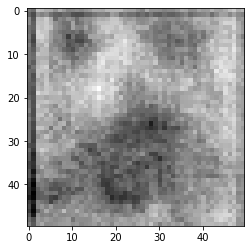

Time for epoch 15 is 367.52853751182556 sec


In [ ]:
train(image_dataset, EPOCHS)